In [181]:
# imported dependencies
import pennylane as qml
from itertools import product
import numpy as np
import random
import stabilizer as stabilizers
from scipy.linalg import expm
qml.version()

'0.28.0'

In [105]:
stabs = stabilizers.get_4_1_2()
G_list = stabs[:-2]
ZL = stabs[-2]
XL = stabs[-1]

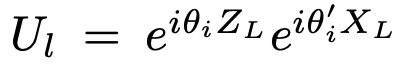

In [182]:
def get_unitary_gate(ZL, XL):
  theta_i = np.random.uniform(0, 2*np.pi)
  theta_i_prime = np.random.uniform(0, 2*np.pi)
  exp_Z_L = expm(1j * theta_i * ZL)
  exp_X_L = expm(1j * theta_i_prime * XL)
    
  return exp_Z_L @ exp_X_L

In [209]:
def get_unitary_gate_test(ZL, XL):
  return np.exp(-2*np.pi*1j) * qml.PauliZ(0).matrix()

def marco_Test(u_list):
    pid = generate_density_matrix()
    for U in u_list:
       pid = U @ pid @ U.conj().T
    return pid


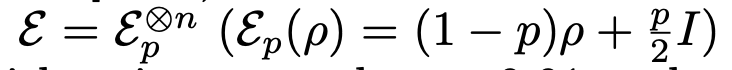

In [107]:
def add_depolarizing_noise(rho, p):
    return (1 - p) * rho + p / 2 * np.identity(rho.shape[0])

In [208]:
# n = 5 (Physical Qubits)
# k = 3 (Logical Qubits)

def generate_density_matrix():
    c1 = 1/np.sqrt(2)
    c2 = 1/np.sqrt(2)
    state = np.array([1, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    rho = np.outer(state, np.conj(state).T)
    return rho

In [104]:
rho = generate_density_matrix()

In [215]:
def find_subsets_of_indicies(index_list):
    index_subsets = []
    dfs_subset_helper(index_list, [], index_subsets)
    return index_subsets[1:] # first is always empty set
    
def dfs_subset_helper(index_list, path, index_subsets):
    index_subsets.append(path)
    for i in range(len(index_list)):
        dfs_subset_helper(index_list[i+1:], path+[index_list[i]], index_subsets)

def create_stabilizer_subset(index_list, G_list):
    ans = []
    for index_set in index_list:
        stabilizer_group = G_list[index_set[0]]
        for i in range(1, len(index_set)):
            next_stabilizer = G_list[index_set[i]]
            stabilizer_group = stabilizer_group @ next_stabilizer
        ans.append(stabilizer_group)
    
    ans.append(np.eye(G_list[0].shape[0]))
    return ans

index_subsets = find_subsets_of_indicies(list(range(len(G_list))))

stabilizer_subsets = create_stabilizer_subset(index_subsets, G_list)

def get_ulist(length, ZL, XL):
    u_list = []
    for i in range(length):
        u_list.append(get_unitary_gate(ZL, XL))
    return u_list

L = 20
estimation_wires = [i for i in range(L)]
target_wires = [L + i for i in range(4)]
dev = qml.device("default.qubit", wires=(len(target_wires + estimation_wires)))
@qml.qnode(dev)
def PID(u_list):
    # stabilizer list is same len as estimation wires
    # initialize target and estimation wires
    for u in u_list:
        qml.QubitUnitary(u, wires=target_wires)

    return qml.density_matrix(target_wires)

In [217]:
dev = qml.device("default.qubit", wires=(len(estimation_wires+target_wires)),shots=1)
@qml.qnode(dev)
def VQED(stabilizer_list, unitary_list, O):
    # stabilizer list is same len as estimation wires
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)
    for l in range(len(estimation_wires)):
        # get the 3 unitary matries
        print(l)
        s_i = stabilizer_list[l][0]
        s_j = stabilizer_list[l][1]
        U = unitary_list[l]
        # apply the gates 
        qml.QubitUnitary(U, wires=target_wires)
        #qml.BitFlip(0.5, wires=estimation_wires[0])
        qml.ControlledQubitUnitary(s_i, control_wires=estimation_wires[l], wires=target_wires, control_values="0")
        qml.ControlledQubitUnitary(s_j, control_wires=estimation_wires[l], wires=target_wires, control_values="1")
    #return qml.expval(qml.PauliX(estimation_wires[0]))
    return qml.expval(qml.PauliX(estimation_wires[0]) @ qml.PauliX(estimation_wires[1]) @ qml.PauliX(estimation_wires[2]) @ qml.PauliX(estimation_wires[3])), qml.expval(qml.Hermitian(O, wires=target_wires))

U_list = get_ulist(L, ZL, XL)
a = 0
b = 0
N = 100
pid = marco_Test(U_list)
for s in range(N):
    print(s)
    s_sample = [random.sample(stabilizer_subsets, 2) for i in range(L)]
    a_s, O_measurement = VQED(s_sample, U_list, pid)
    b_s = a_s * O_measurement
    a += a_s
    b += b_s

a = a/N
b = b/N

print("a:")
print(a)

print("b:")
print(b)

print("b/a:")
print(b/a)

cache[L] = b/a

cache





0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
def find_subsets_of_indicies(index_list):
    index_subsets = []
    dfs_subset_helper(index_list, [], index_subsets)
    return index_subsets[1:] # first is always empty set
    
def dfs_subset_helper(index_list, path, index_subsets):
    index_subsets.append(path)
    for i in range(len(index_list)):
        dfs_subset_helper(index_list[i+1:], path+[index_list[i]], index_subsets)

def create_stabilizer_subset(index_list, G_list):
    ans = []
    for index_set in index_list:
        stabilizer_group = G_list[index_set[0]]
        for i in range(1, len(index_set)):
            next_stabilizer = G_list[index_set[i]]
            stabilizer_group = stabilizer_group @ next_stabilizer
        ans.append(stabilizer_group)
    
    ans.append(np.eye(G_list[0].shape[0]))
    return ans

# Testing functions above to create stabiizer groups
G_list = stabilizers.get_4_1_2()
print(len(G_list))

index_subsets = find_subsets_of_indicies(list(range(len(G_list))))
print(index_subsets)

stabilizer_subsets = create_stabilizer_subset(index_subsets, G_list)
print(len(stabilizer_subsets))

5
[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1, 2, 4], [0, 1, 3], [0, 1, 3, 4], [0, 1, 4], [0, 2], [0, 2, 3], [0, 2, 3, 4], [0, 2, 4], [0, 3], [0, 3, 4], [0, 4], [1], [1, 2], [1, 2, 3], [1, 2, 3, 4], [1, 2, 4], [1, 3], [1, 3, 4], [1, 4], [2], [2, 3], [2, 3, 4], [2, 4], [3], [3, 4], [4]]
32


In [ ]:
L = len(U_list)
rho_naught = generate_density_matrix()
estimation_wires = list(range(0, L))
target_wires = list(range(L, L+3))

In [ ]:
def run_at_depth_l(l, ZL, XL):
    U_list = [get_unitary_gate(ZL, XL) for i in range(l)]
    

In [180]:
from scipy.linalg import expm
def fffff():
  F  = qml.RY(1,0).matrix()
  print(F)
  test = expm(-1j * 1/2 * qml.PauliY(0).matrix())
  #test = np.exp(-1j * 1/2 * qml.PauliY(0).matrix())
  print(test)

fffff()

[[ 0.87758256+0.j -0.47942554-0.j]
 [ 0.47942554+0.j  0.87758256+0.j]]
[[ 0.87758256+0.j -0.47942554+0.j]
 [ 0.47942554+0.j  0.87758256+0.j]]
